In [1]:
import sys
sys.path.insert(0, "../")
from SC_Utils.game_utils import ObsProcesser, get_action_dict
from SC_Utils.train_v2 import *
from SC_Utils.inspection_plots import *
import AC_modules.Networks as net
from AC_modules.BatchedA2C import SpatialA2C, SpatialA2C_v1, SpatialA2C_v2, SpatialA2C_v3
import torch
import numpy as np
import matplotlib.pyplot as plt

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# Online plotting of the training

In [2]:
#filename = '../Results/FindAndDefeatZerglings/Logging/PRGY.txt'
filename = '../Results/MoveToBeacon/Logging/SFFA.txt'
logging = np.loadtxt(filename, delimiter=',', skiprows=1)

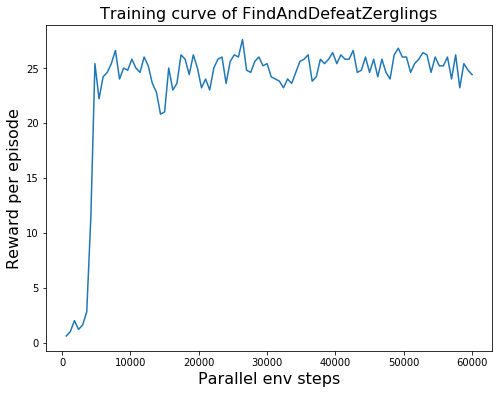

In [3]:
plt.figure(figsize=(8,6))
plt.plot(logging[:,0], logging[:,1])
plt.xlabel("Parallel env steps", fontsize=16)
plt.ylabel("Reward per episode", fontsize=16)
plt.title("Training curve of FindAndDefeatZerglings", fontsize=16)
plt.show()

In [4]:
jump = 120000
n = 26
step_idx =jump*n
step_idx

3120000

# Trajectories

In [5]:
game_names = {1:'MoveToBeacon',
              2:'CollectMineralShards',
              3:'DefeatRoaches',
              4:'FindAndDefeatZerglings',
              5:'DefeatZerglingsAndBanelings',
              6:'CollectMineralsAndGas',
              7:'BuildMarines'
              }
map_name = game_names[4]

In [6]:
load_dir = "../Results/"+map_name+"/Inspection/"
PID = "PRGY"
step_idx = step_idx
insp_dict = np.load(load_dir+PID+"_"+str(step_idx)+".npy", allow_pickle=True).item()

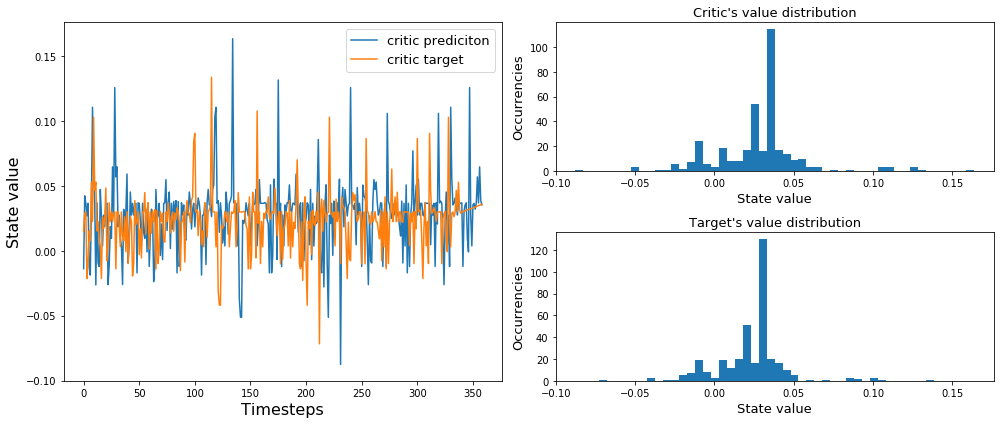

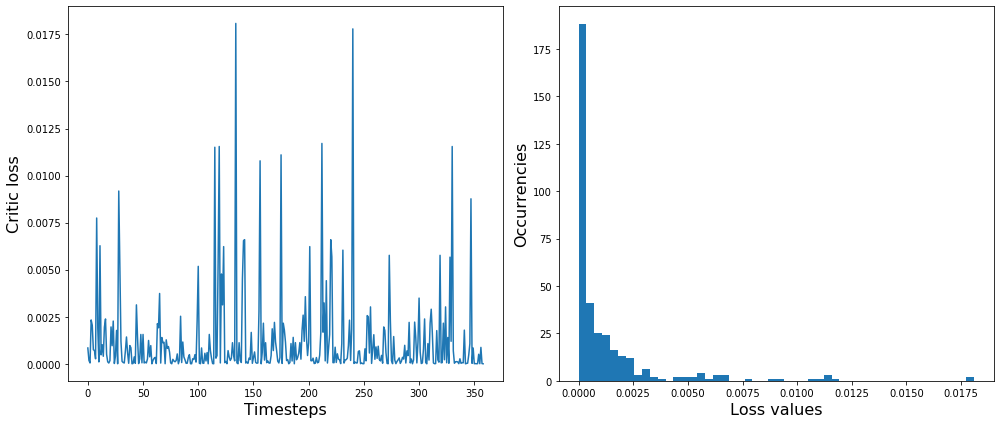

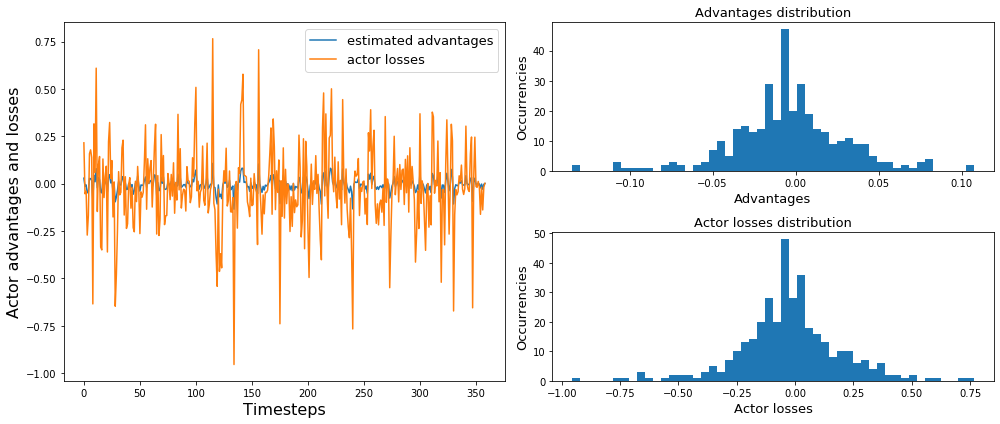

In [7]:
plot_update_curves(insp_dict)

# Agent related visualization

In [4]:
# Environment parameters
RESOLUTION = 32
MAX_STEPS = 256
game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 
game_names = {1:'MoveToBeacon',
              2:'CollectMineralShards',
              3:'DefeatRoaches',
              4:'FindAndDefeatZerglings',
              5:'DefeatZerglingsAndBanelings',
              6:'CollectMineralsAndGas',
              7:'BuildMarines'
              }
map_name = game_names[1]

# Observation Processer parameters
#screen_names = ['visibility_map', 'player_relative', 'selected', 'unit_density', 'unit_density_aa']
#minimap_names = []
#obs_proc_params = {'screen_names':screen_names, 'minimap_names':minimap_names}
obs_proc_params = {'select_all':True}
env = init_game(game_params, map_name)
op = ObsProcesser(**obs_proc_params)
screen_channels, minimap_channels = op.get_n_channels()
in_channels = screen_channels + minimap_channels 
action_names = ['select_army', 'Attack_screen', 'Move_screen']
#action_names = ['no_op', 'select_army', 'Attack_screen', 'Move_screen', 'select_point', 'select_rect']
#action_names = ['select_army', 'Attack_screen', 'Move_screen', 'select_point', 'select_rect',
#                'move_camera','Stop_quick','Move_minimap','Attack_minimap','HoldPosition_quick']
action_dict = get_action_dict(action_names)

In [5]:
PID = 'SFFA'#'HHRC'
load=True
if load:
    agent = torch.load("../Results/"+map_name+"/agent_"+PID, map_location='cpu')
    agent.device = 'cpu'
else:
    action_space = len(action_dict)
    spatial_model = net.FullyConvSpatial
    nonspatial_model = net.FullyConvNonSpatial
    embed_dim = 8
    n_channels = 32
    n_features = 256
    spatial_dict = {"in_channels":in_channels}
    nonspatial_dict = {'resolution':RESOLUTION, 'kernel_size':3, 'stride':2}
    HPs = dict(action_space=action_space, n_steps=20, H=1e-3, 
           spatial_model=spatial_model, nonspatial_model=nonspatial_model,
           n_features=n_features, n_channels=n_channels, 
           spatial_dict=spatial_dict, nonspatial_dict=nonspatial_dict, 
           action_dict=action_dict)

    HPs['device'] = 'cpu'
    version = 2
    if version == 1:
        HPs = {**HPs, 'embed_dim':embed_dim}
        agent = SpatialA2C_v1(env=env, **HPs)
    elif version == 2:
        # no action embedding
        agent = SpatialA2C_v2(env=env, **HPs)
    elif version == 3:
        agent = SpatialA2C_v3(env=env, **HPs)
    else:
        raise Exception("Version not implemented.")
        
    # Load proper checkpoint here

In [6]:
step_idx = 120000

In [7]:
inspector = inspection_test(step_idx, agent, env, PID, op, action_dict)

In [8]:
_, layer_names = op.get_state(env.reset())
layer_names

{'screen_names': array(['visibility_map_1', 'visibility_map_2', 'player_id_1',
        'player_id_2', 'player_id_16', 'player_relative_1',
        'player_relative_3', 'player_relative_4', 'unit_type_9',
        'unit_type_18', 'unit_type_20', 'unit_type_45', 'unit_type_48',
        'unit_type_105', 'unit_type_110', 'unit_type_317', 'unit_type_341',
        'unit_type_342', 'unit_type_1680', 'selected_1', 'unit_hit_points',
        'unit_hit_points_ratio', 'unit_density', 'unit_density_aa',
        'pathable_1', 'buildable_1'], dtype='<U21'),
 'minimap_names': array(['visibility_map_1', 'visibility_map_2', 'camera_1', 'player_id_1',
        'player_id_2', 'player_id_16', 'player_relative_1',
        'player_relative_3', 'player_relative_4', 'selected_1',
        'pathable_1', 'buildable_1'], dtype='<U17')}

In [7]:
remove_names = ['unit_type_20','unit_type_45'] # added after the inspection was done
layer_names['screen_names'] = np.array([name for name in layer_names['screen_names'] if name not in remove_names])
layer_names['screen_names']

array(['visibility_map_1', 'visibility_map_2', 'player_id_1',
       'player_id_2', 'player_id_16', 'player_relative_1',
       'player_relative_3', 'player_relative_4', 'unit_type_9',
       'unit_type_18', 'unit_type_48', 'unit_type_105', 'unit_type_110',
       'unit_type_317', 'unit_type_341', 'unit_type_342',
       'unit_type_1680', 'selected_1', 'unit_hit_points',
       'unit_hit_points_ratio', 'unit_density', 'unit_density_aa',
       'pathable_1', 'buildable_1'], dtype='<U21')

In [9]:
insp_dict = inspector.dict


Step 0
Action select_army - prob: 1.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  select_army


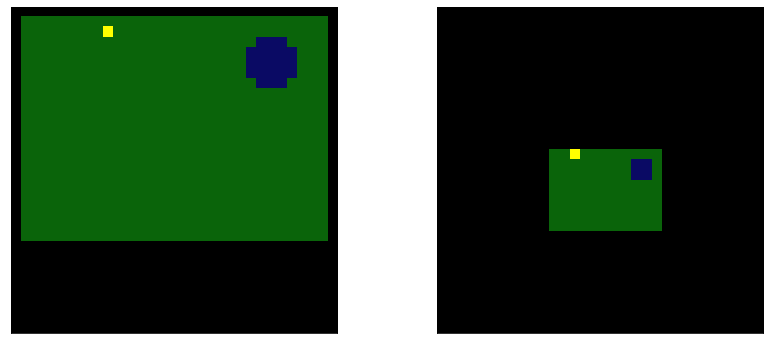

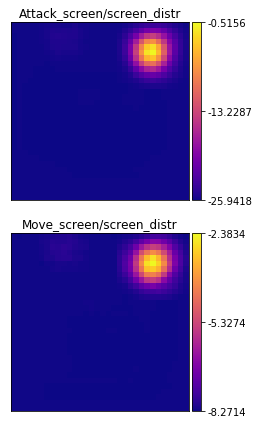


Step 1
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


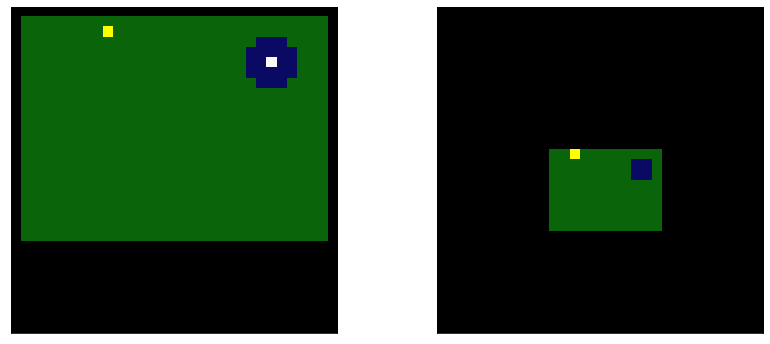

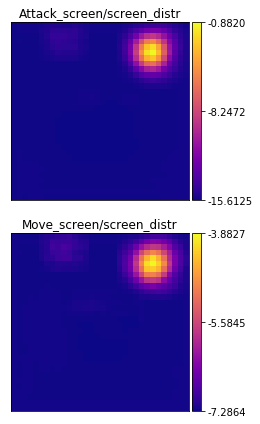


Step 2
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


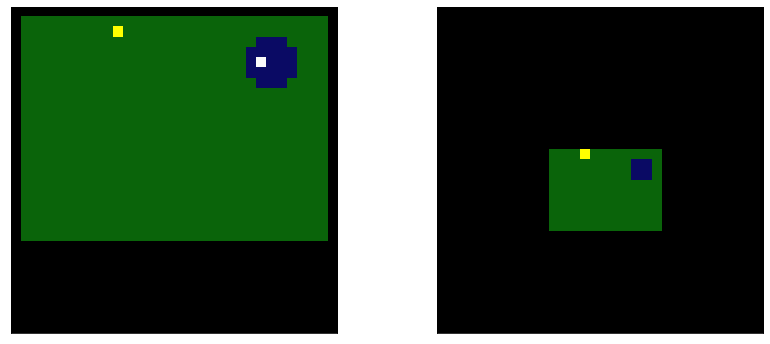

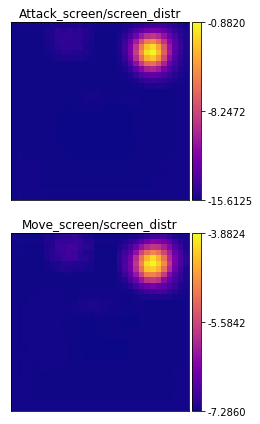


Step 3
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


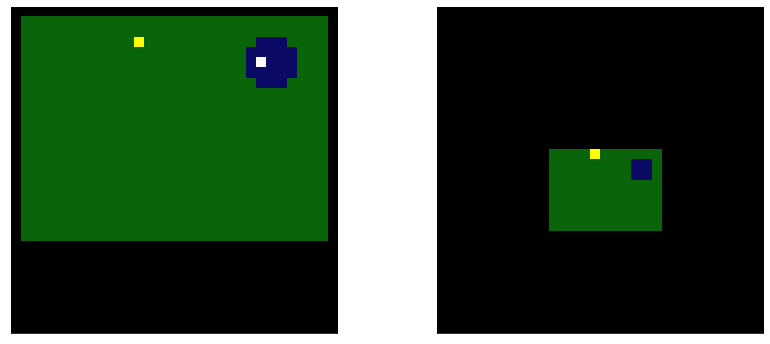

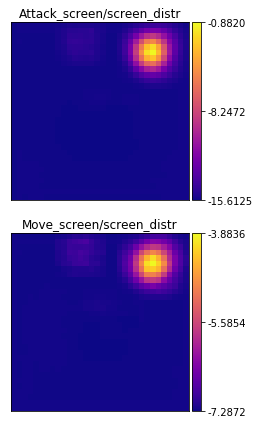


Step 4
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


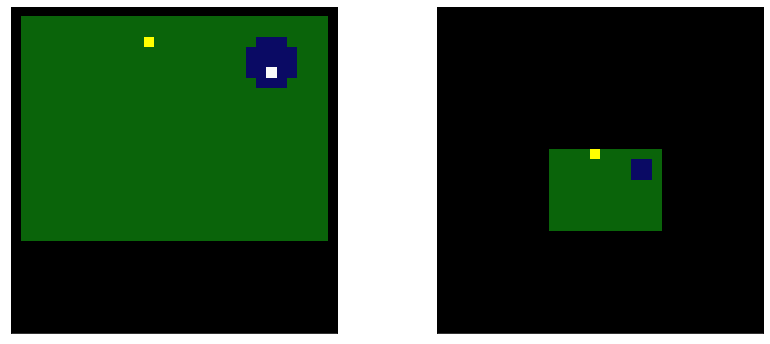

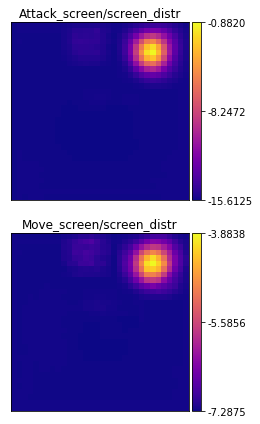


Step 5
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


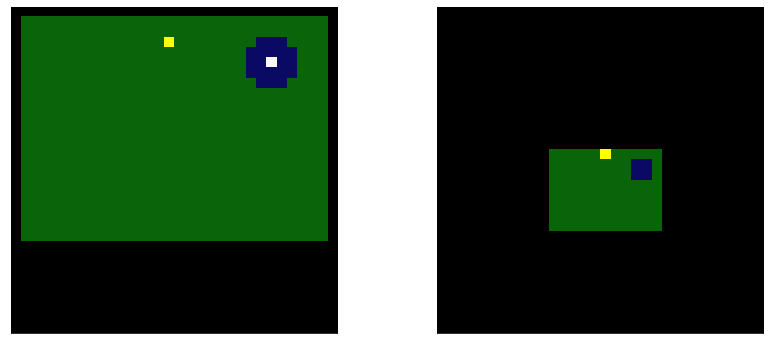

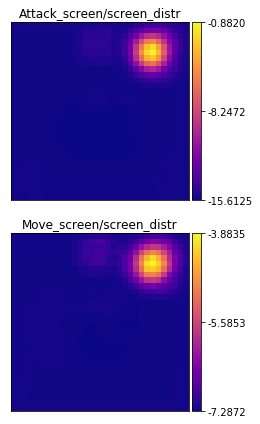


Step 6
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


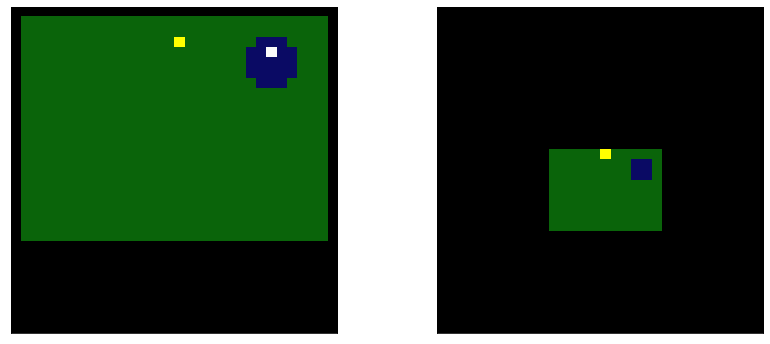

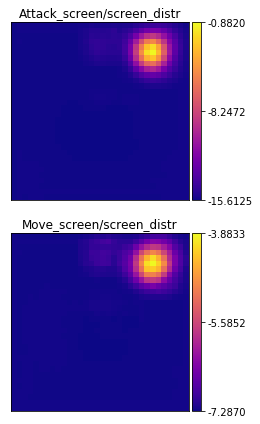


Step 7
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


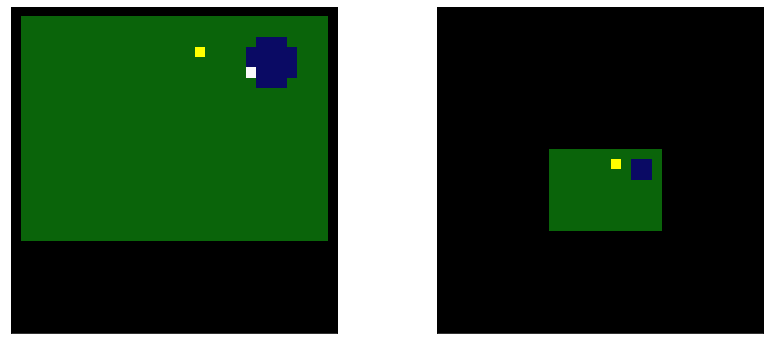

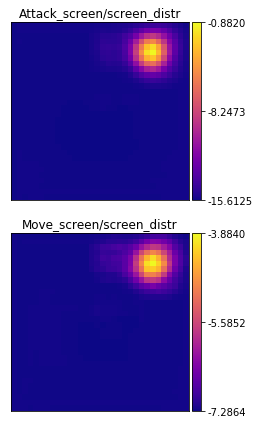


Step 8
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


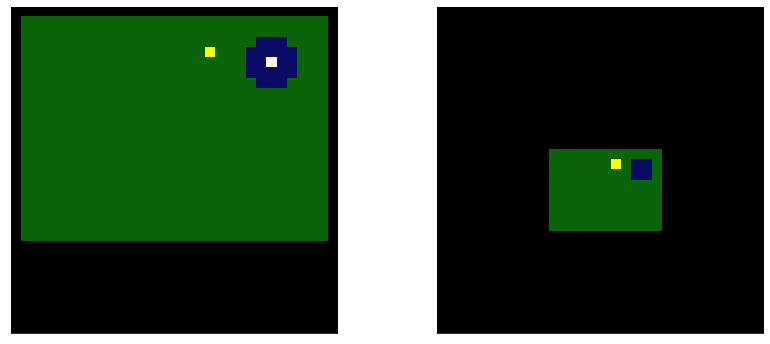

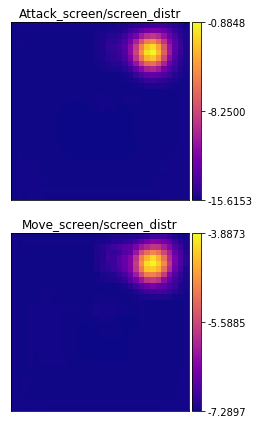


Step 9
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


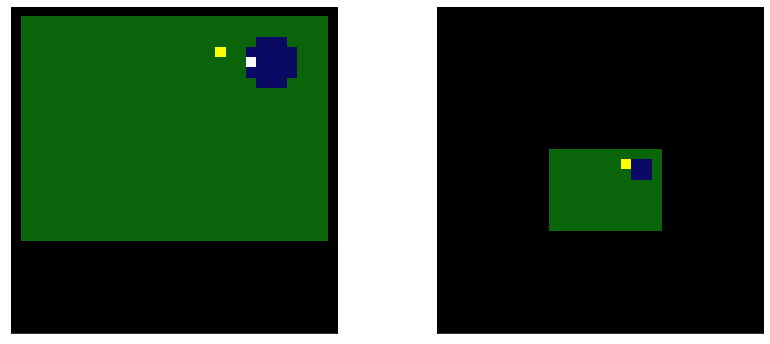

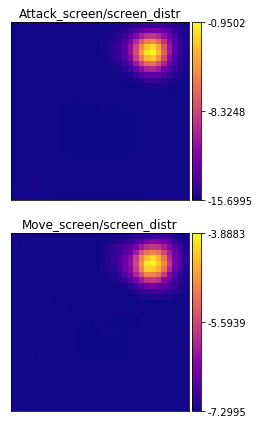


Step 10
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


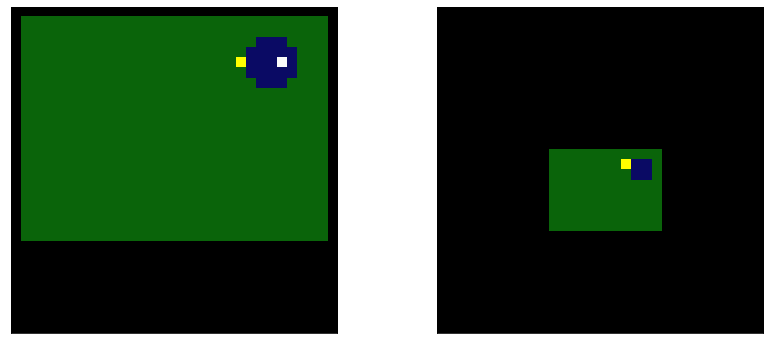

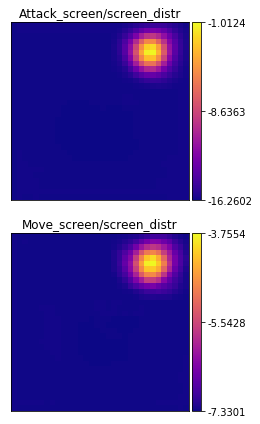


Step 11
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


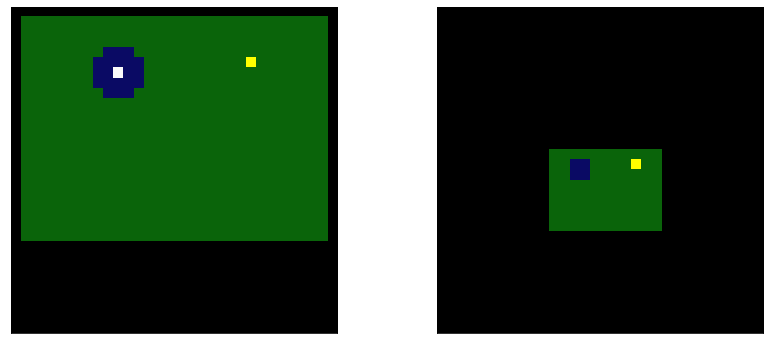

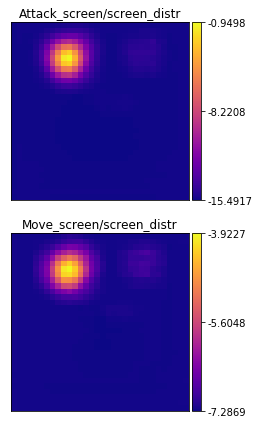


Step 12
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


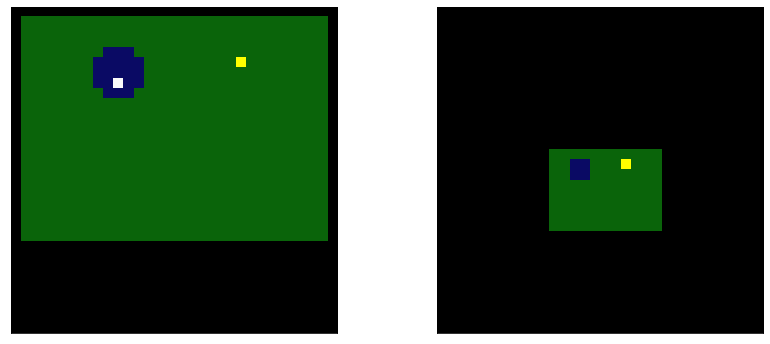

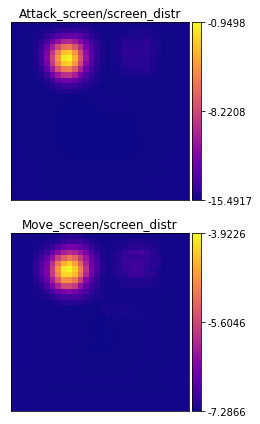


Step 13
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


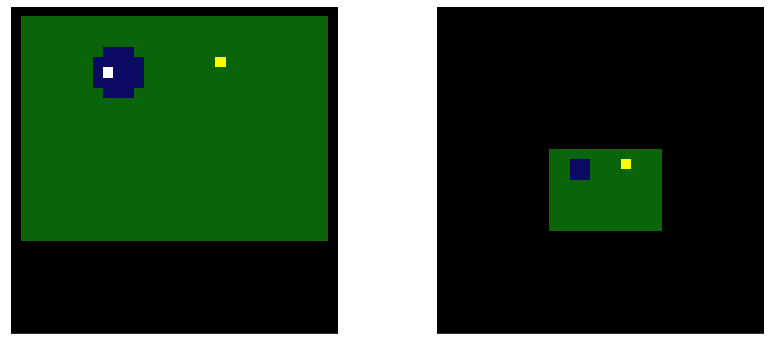

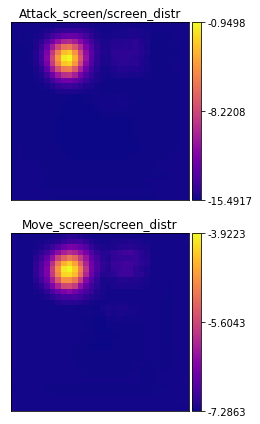


Step 14
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


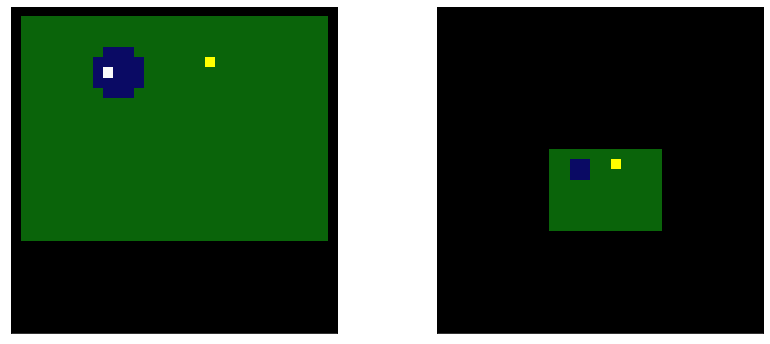

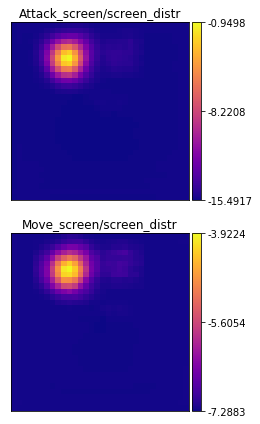


Step 15
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


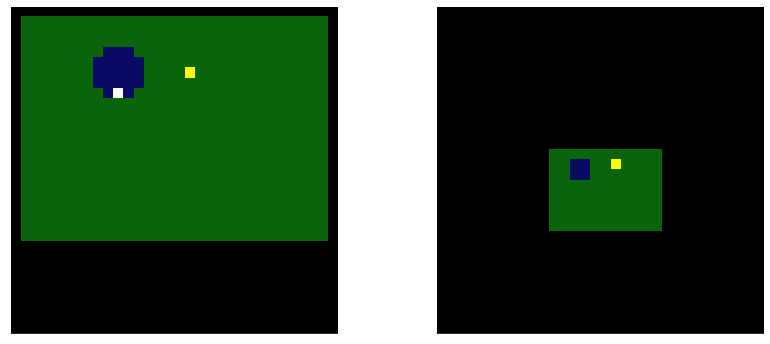

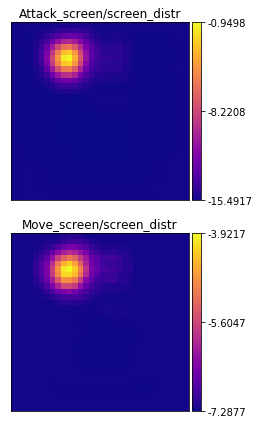


Step 16
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


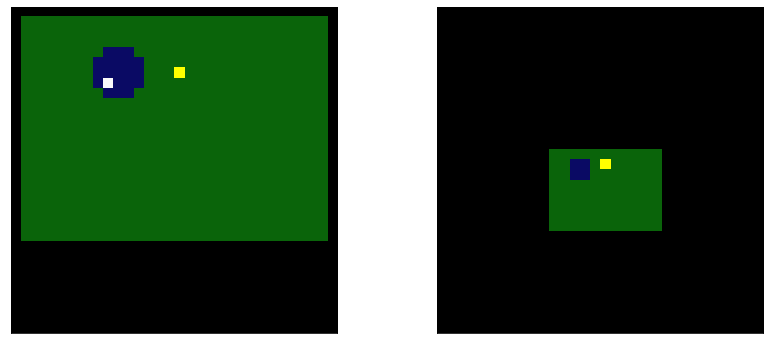

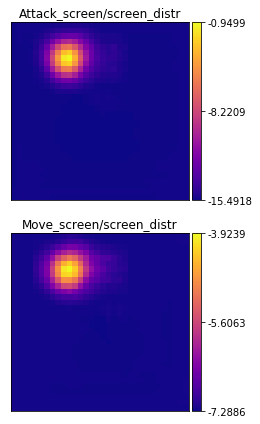


Step 17
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


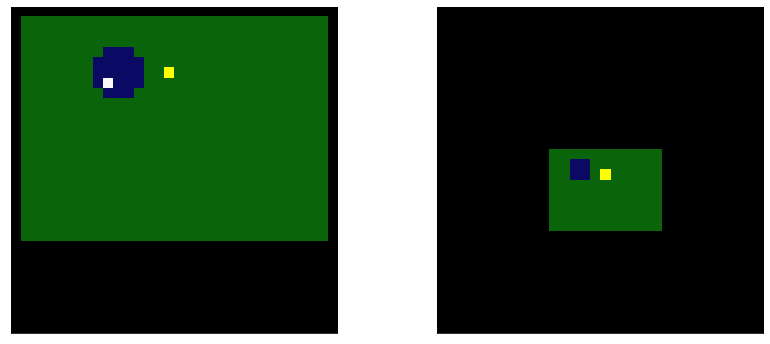

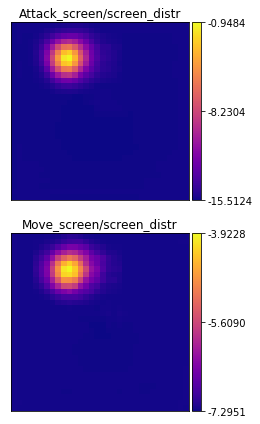


Step 18
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


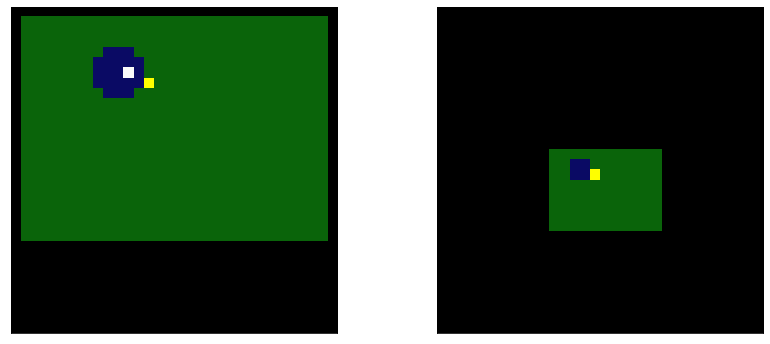

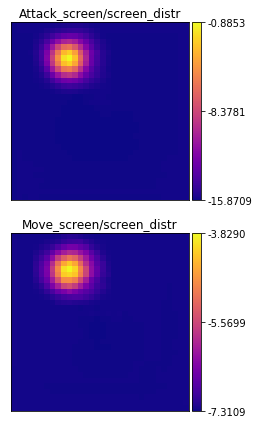


Step 19
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


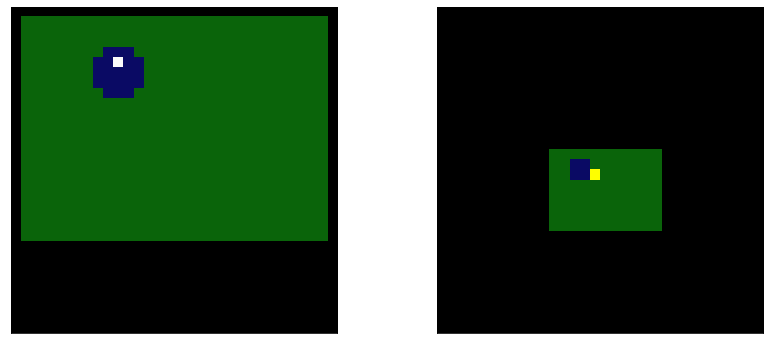

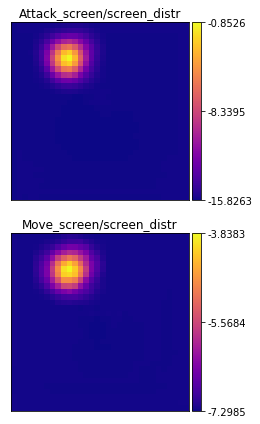


Step 20
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


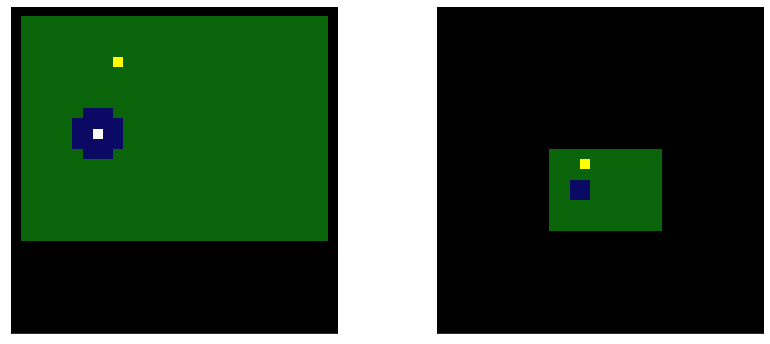

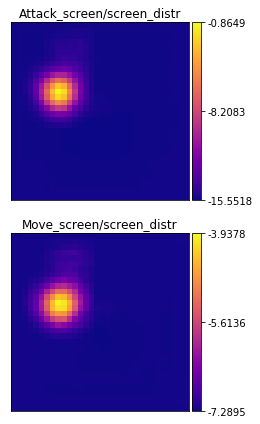


Step 21
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


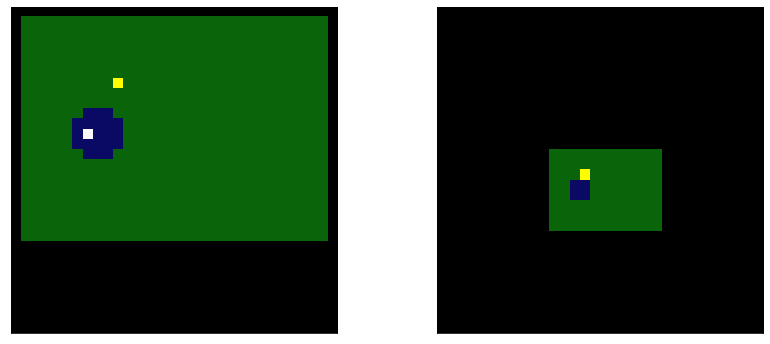

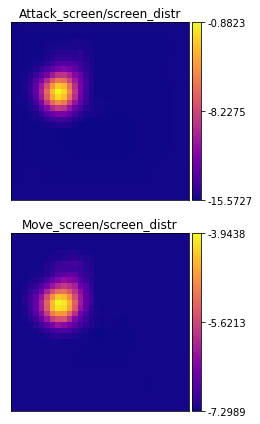


Step 22
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


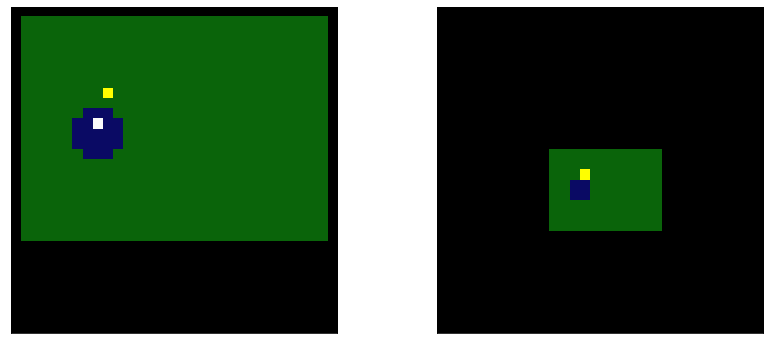

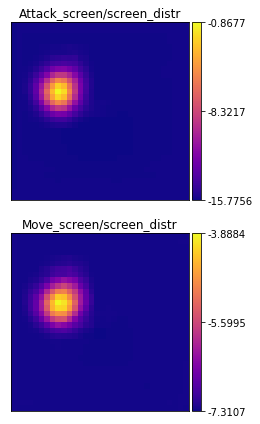


Step 23
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


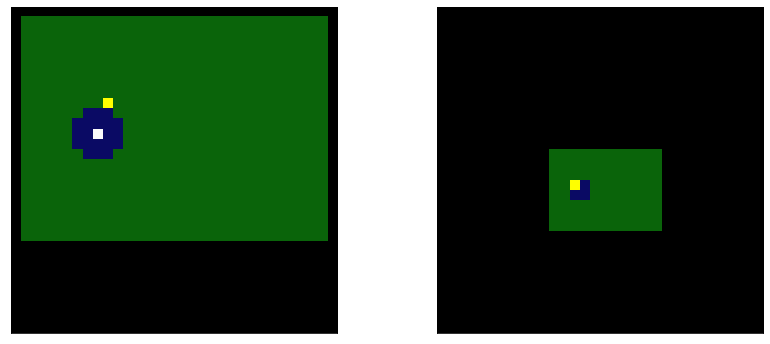

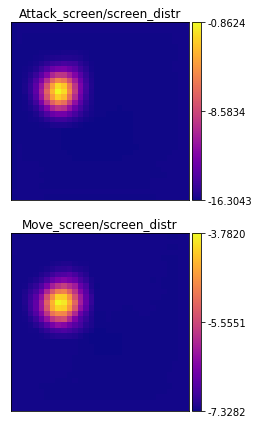


Step 24
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


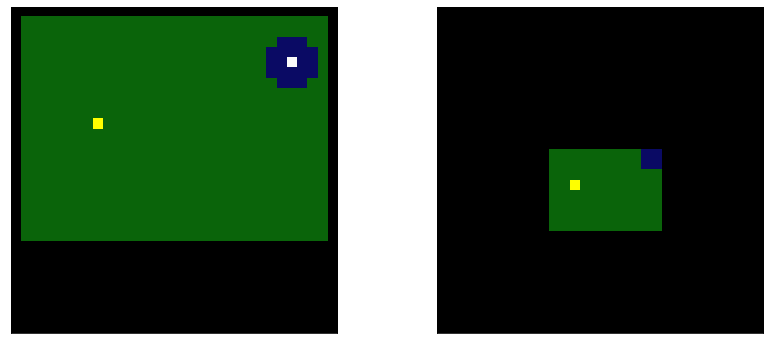

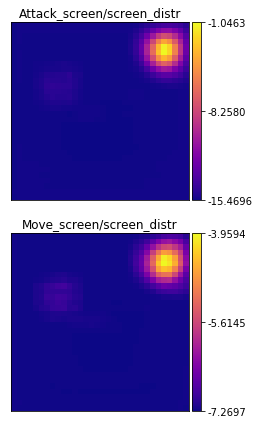


Step 25
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


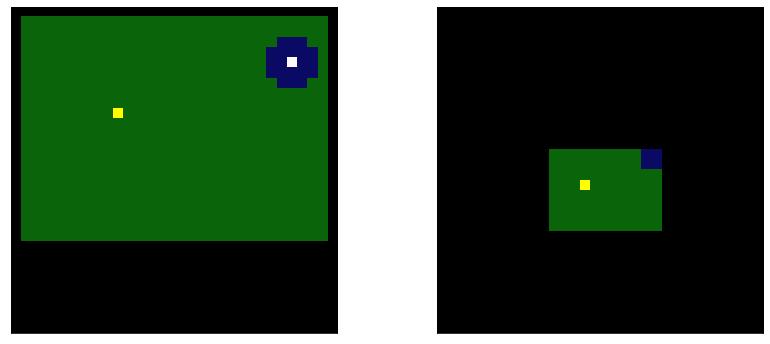

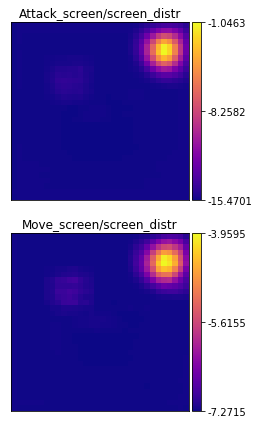


Step 26
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


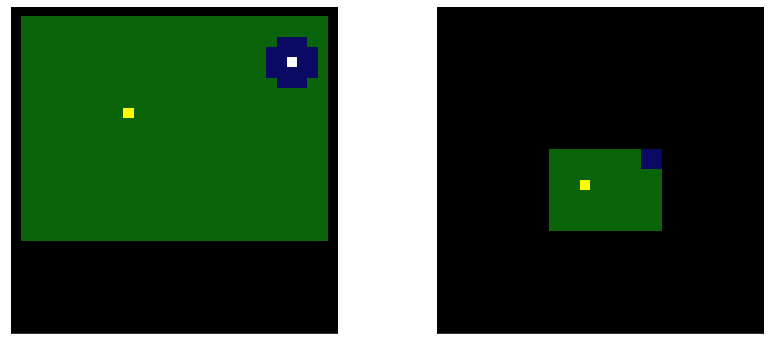

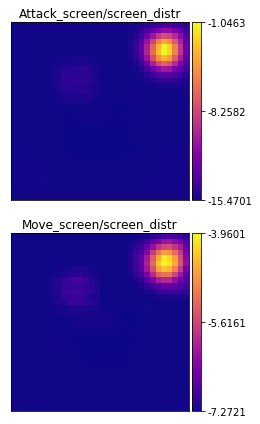


Step 27
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


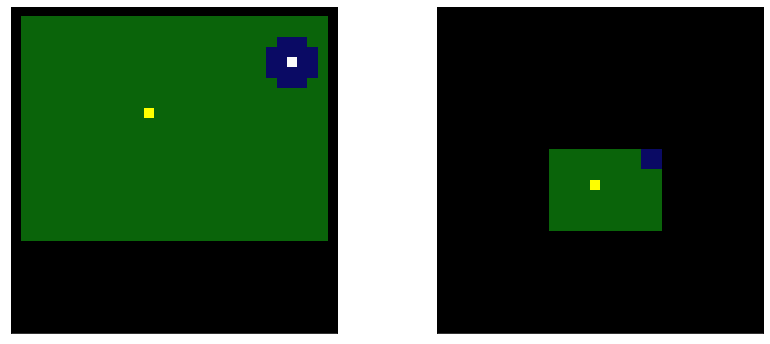

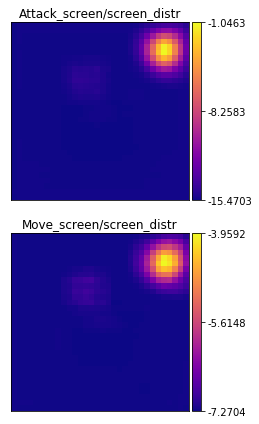


Step 28
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


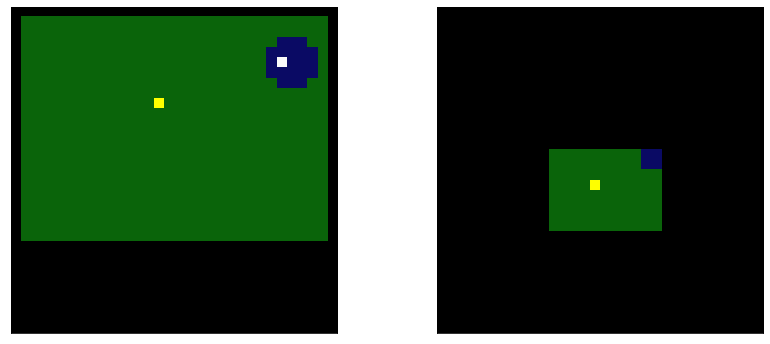

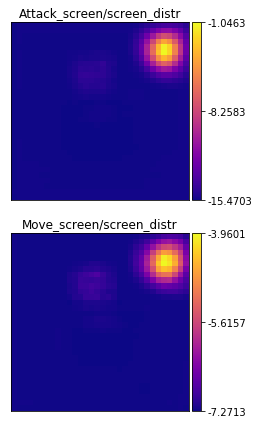


Step 29
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


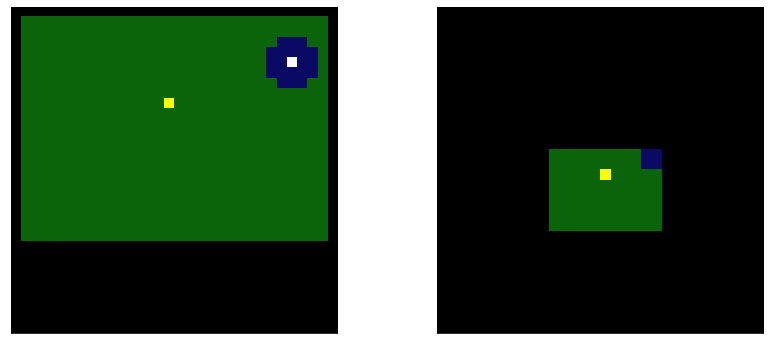

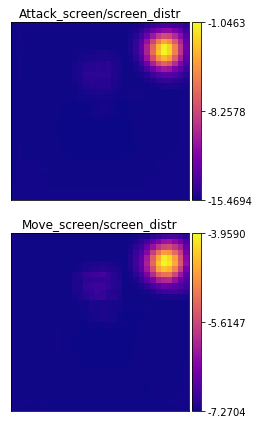


Step 30
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


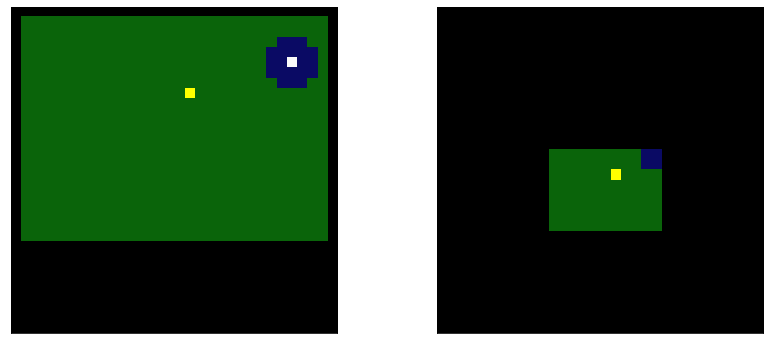

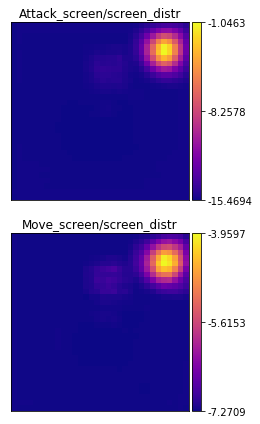


Step 31
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


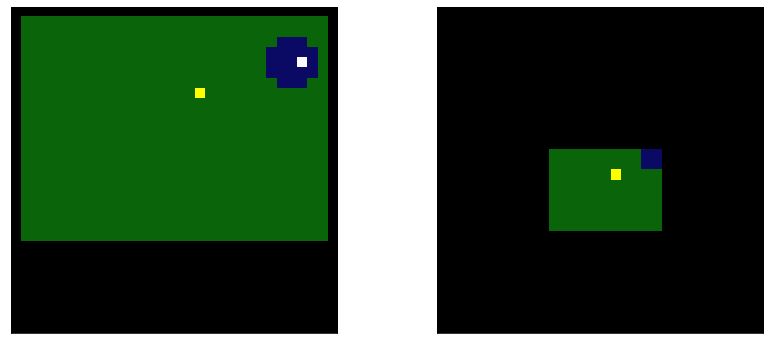

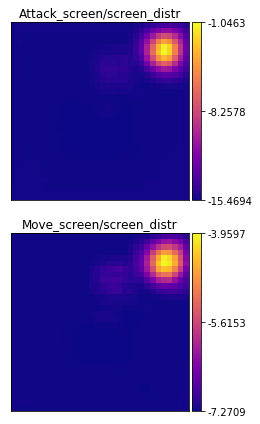


Step 32
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


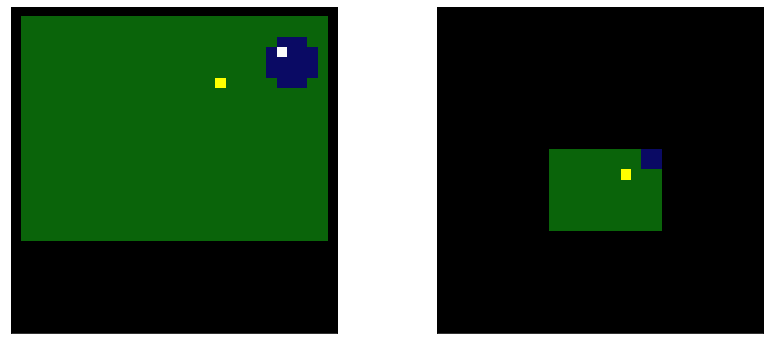

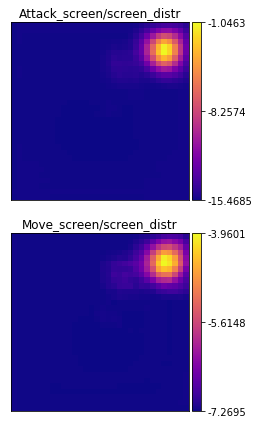


Step 33
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


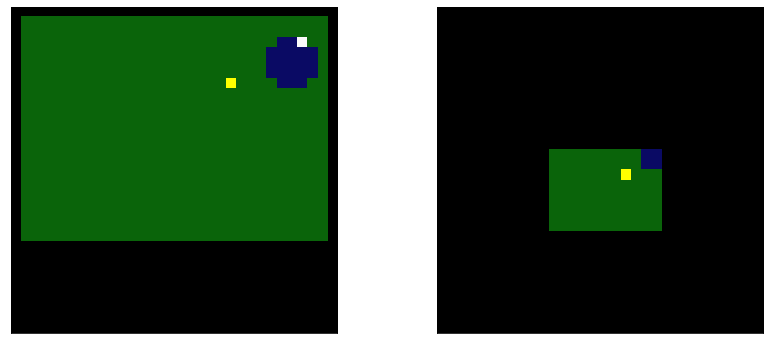

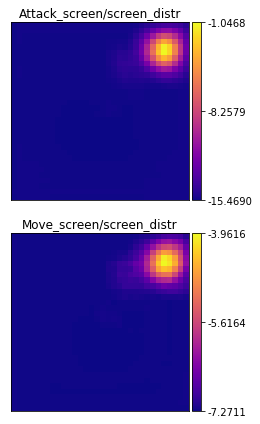


Step 34
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


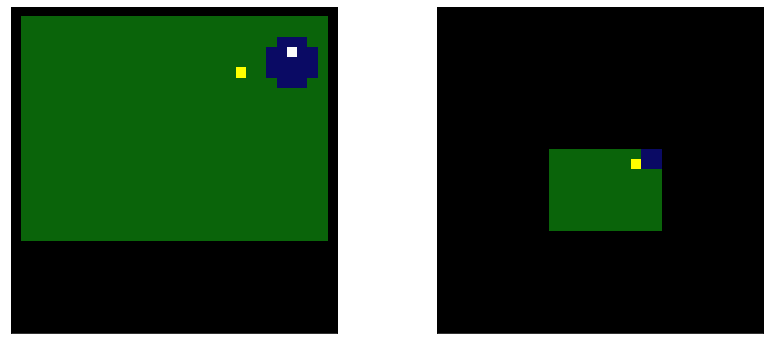

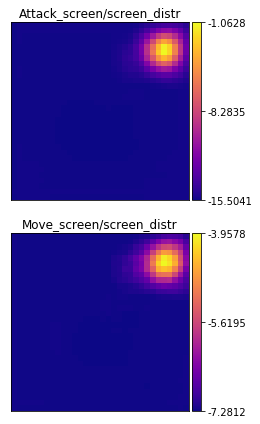


Step 35
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


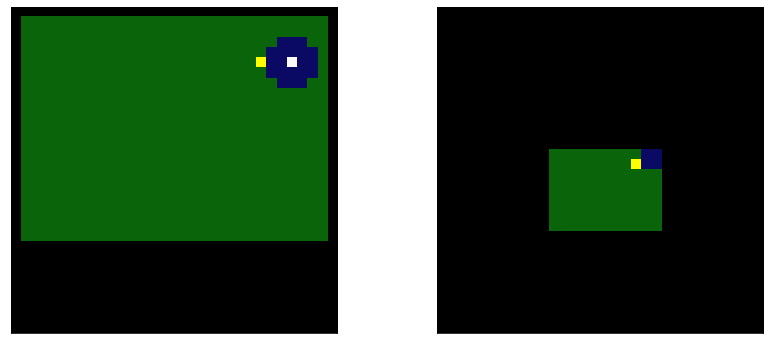

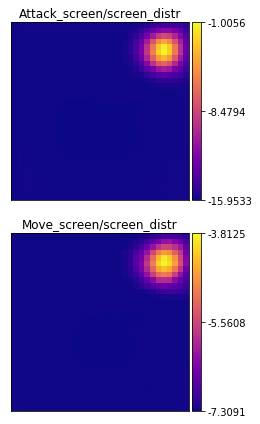


Step 36
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


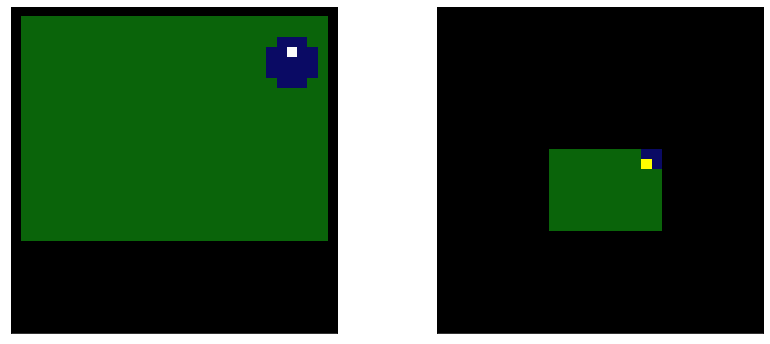

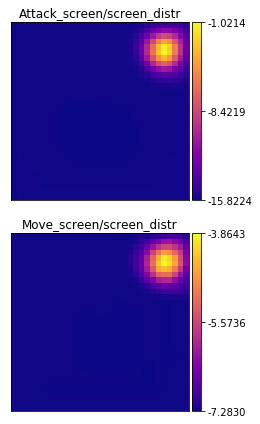


Step 37
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


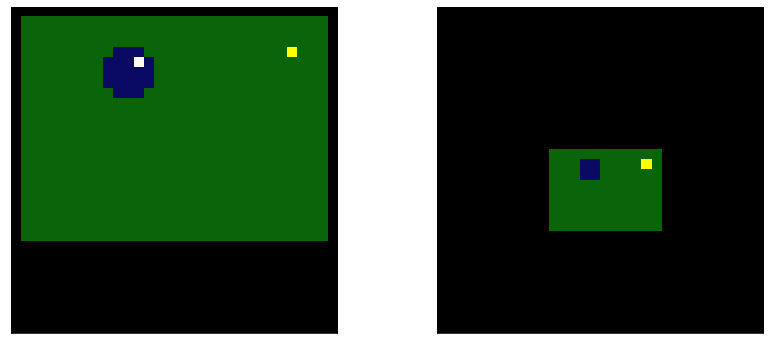

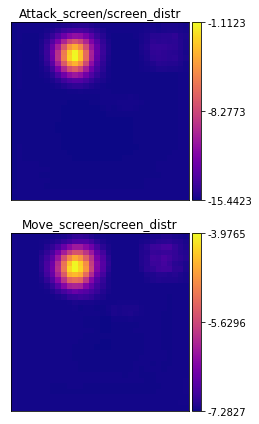


Step 38
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


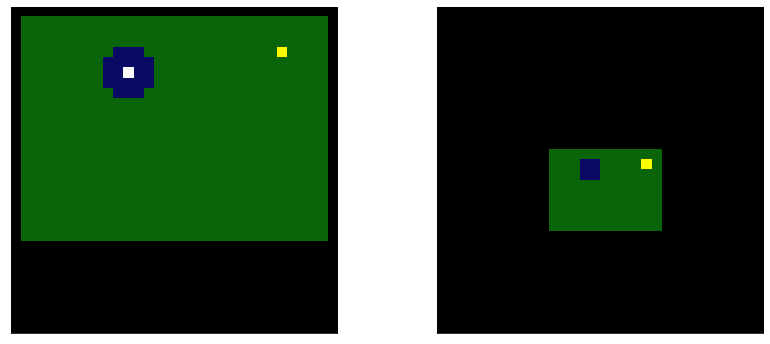

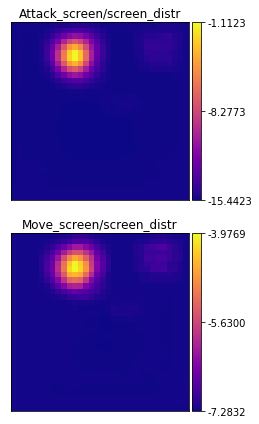


Step 39
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


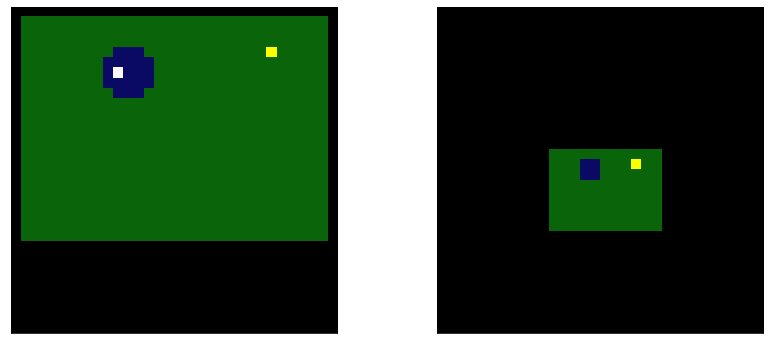

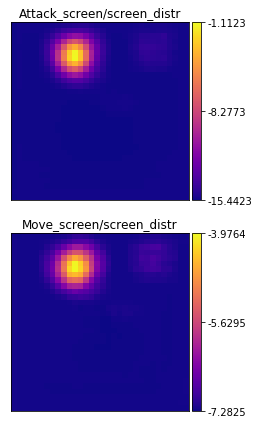


Step 40
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


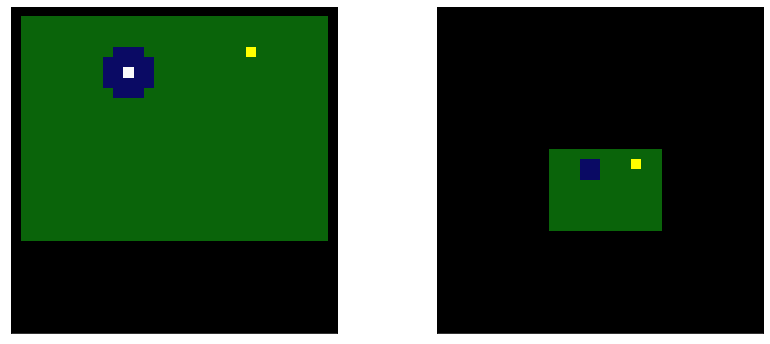

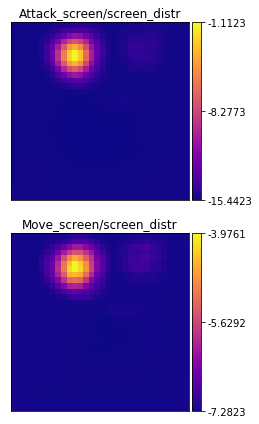


Step 41
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


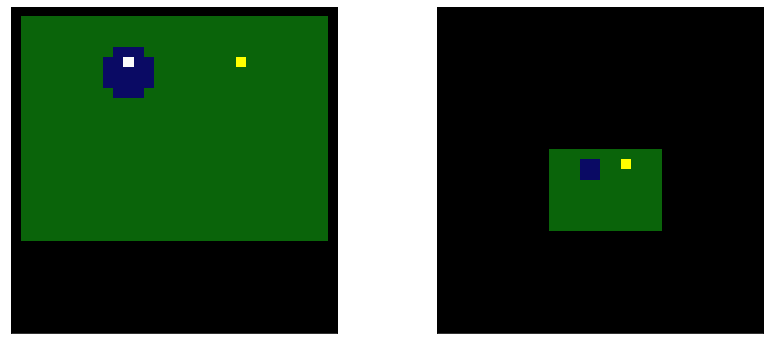

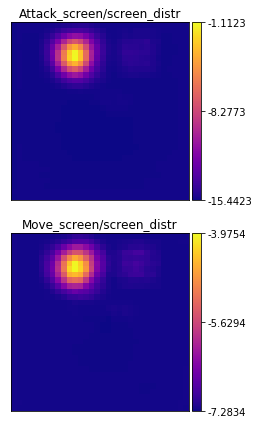


Step 42
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


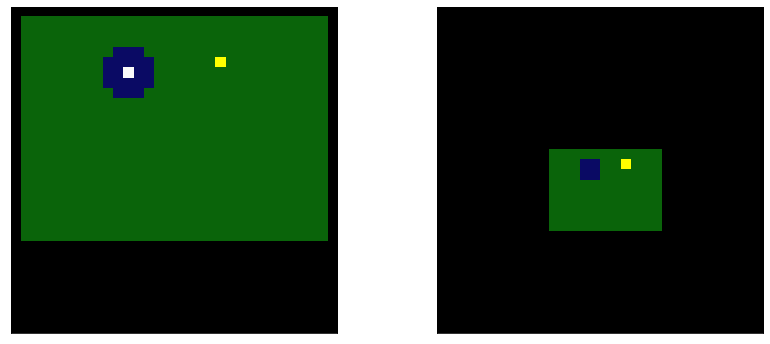

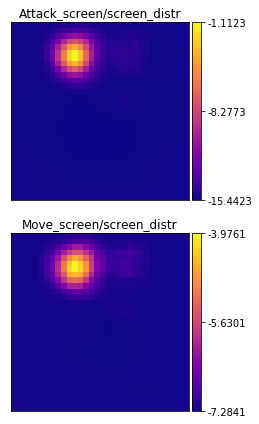


Step 43
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


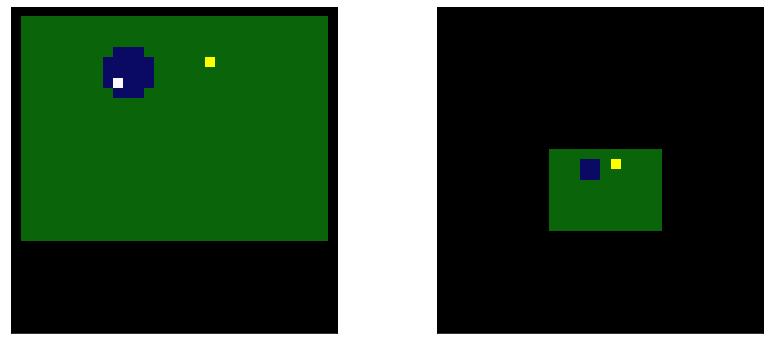

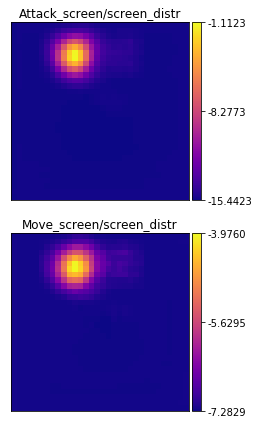


Step 44
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


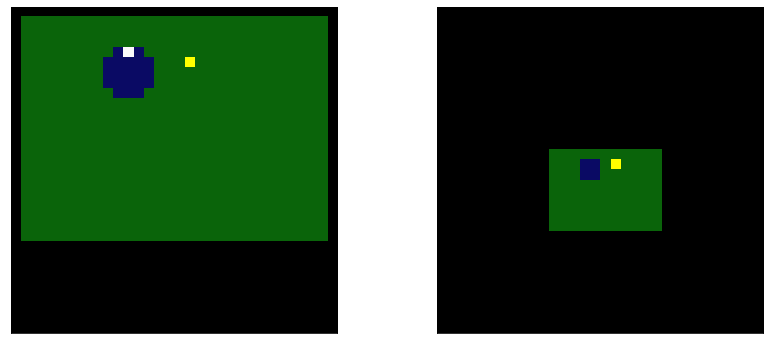

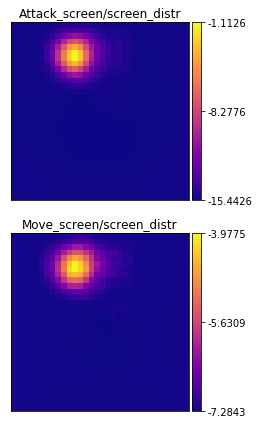


Step 45
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


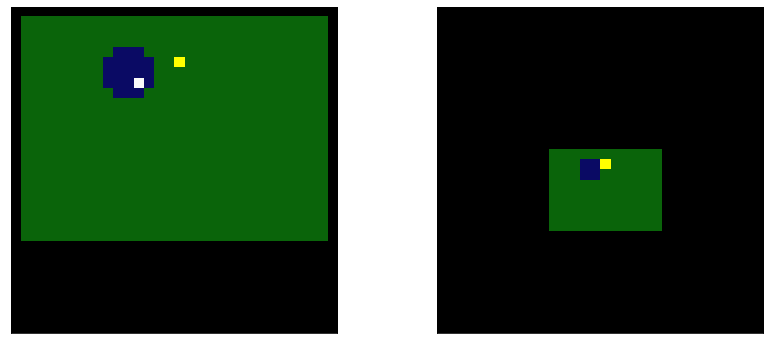

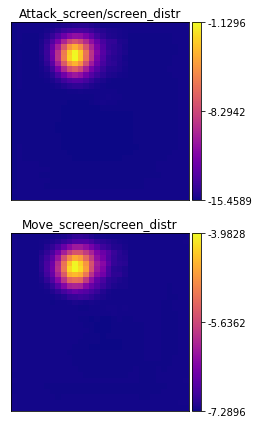


Step 46
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


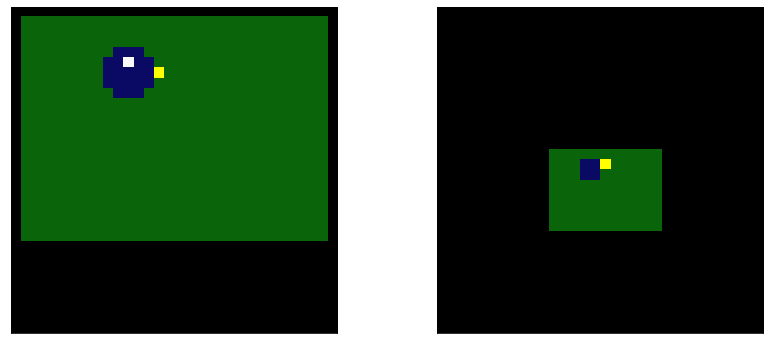

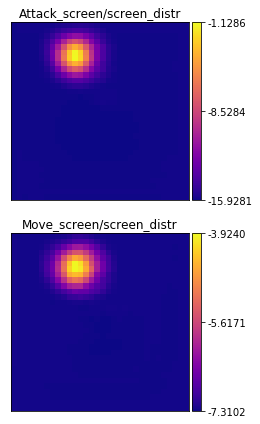


Step 47
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


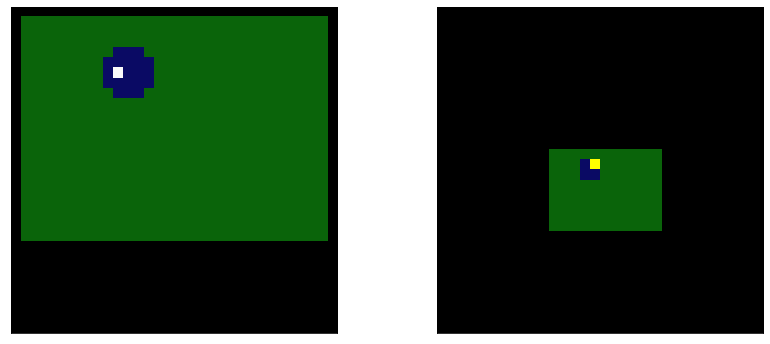

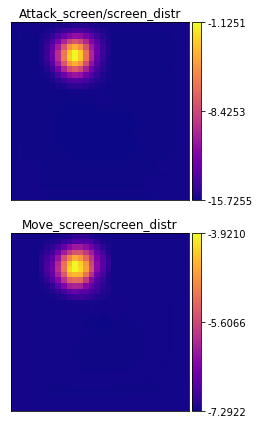


Step 48
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


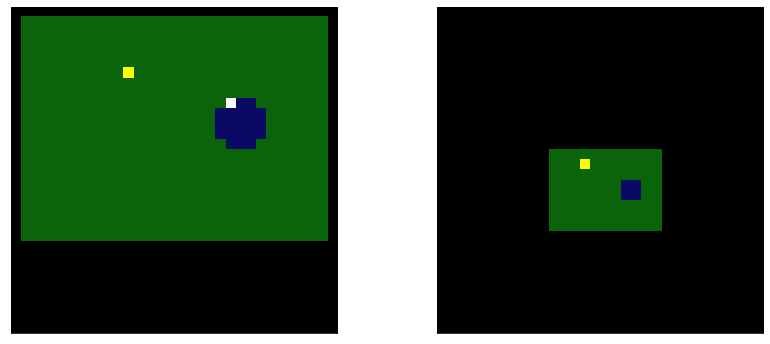

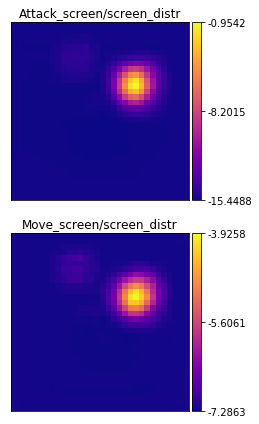


Step 49
Action select_army - prob: 0.00
Action Attack_screen - prob: 1.00
Action Move_screen - prob: 0.00
-----------------------------------
Action chosen:  Attack_screen


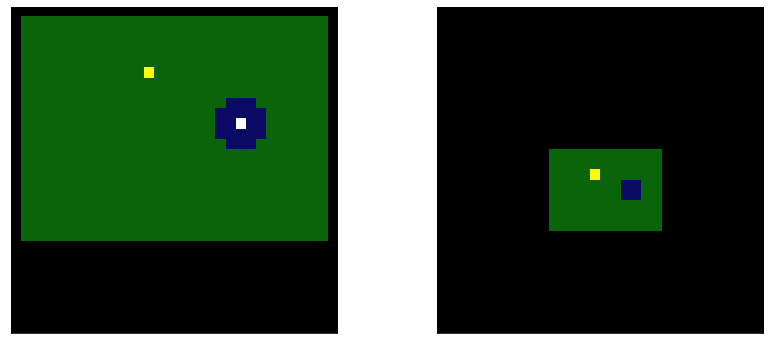

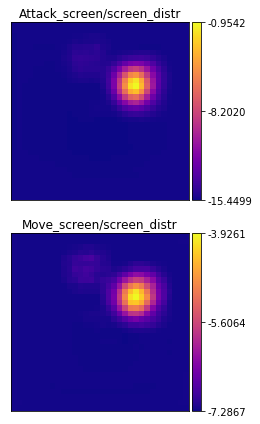

In [10]:
#for t in range(len(insp_dict['state_traj'])):
for t in range(50):
    print_action_info(inspector, insp_dict, t)
    plot_screen_and_decision(inspector, insp_dict, layer_names, t, show_minimap=True)
    #plot_screen_layers(insp_dict, layer_names, t)
    #plot_minimap_layers(insp_dict, layer_names, t)

# Entropy regularization test

1. $H=10^{-3}$, `PID='HHRC'`: 
    - Attack_screen 100% of the times
    
2. $H=10^{-2}$, `PID='ITJU'`: 
    - Action select_army - 9%
    - Action Attack_screen - 3%
    - Action Move_screen - 89%
    
3. $H=10^{-1}$, `PID='NQIB'`:
    - Action select_army - 33%
    - Action Attack_screen - 33%
    - Action Move_screen - 34%
    
4. Linear annealing from $H=10^{-2}$ to $H=10^{-2}$, `PID='SFFA'`:
    - Attack_screen 100% of the times
    
So it seems that we have a problem, in the sense that within an order of magnitude we go from ininfluent regularization to a regularization that becomes the main objective.
We might have some options to do better:
1. Fine-tune H between $10^{-2}$ and $10^{-3}$
2. Use an annealing scheme for H, e.g. linear annealing

In [29]:
H_init = 1e-2
H_end = 1e-3
max_train_steps = 120000
unroll_length = 60
step_idx = unroll_length*2 # the important is to keep it a multiple of unroll_length / traj_length

class H_linear_schedule():
    def __init__(self, H_init, H_end, max_train_steps):
        self.H0 = H_init
        self.m = (H_end-H_init)/max_train_steps
        self.max_steps = max_train_steps
        
    def get_H(self, step_idx):
        # clip at max_step (independent assurance from init conditions)
        if step_idx > self.max_steps:
            step_idx = self.max_steps
        return self.H0 + self.m*step_idx

In [30]:
H_sched = H_linear_schedule(H_init, H_end, max_train_steps)
Hs = []
steps = [i for i in range(0, max_train_steps, 60)]
Hs = list(map(H_sched.get_H, steps))

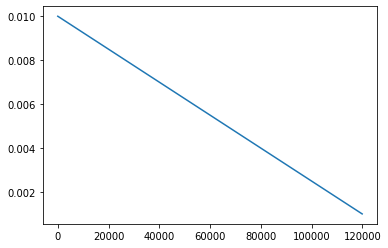

In [31]:
plt.plot(steps, Hs)